## Import

In [ ]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import nibabel as nib

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

## Data Load

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/chest_xray.zip')
zip_file.extractall('/content/datasets')
zip_file.close()

In [ ]:
PATH = '/content/datasets/chest_xray/'

from glob import glob

normal_train_data = glob(PATH + 'train/NORMAL/*.jpeg')
pneumonia_train_data = glob(PATH + 'train/PNEUMONIA/*.jpeg')
normal_val_data = glob(PATH + 'val/NORMAL/*.jpeg')
pneumonia_val_data = glob(PATH + 'val/PNEUMONIA/*.jpeg')
normal_test_data = glob(PATH + 'test/NORMAL/*.jpeg')
pneumonia_test_data = glob(PATH + 'test/PNEUMONIA/*.jpeg')

In [ ]:
train_path  = normal_train_data + pneumonia_train_data
val_path = normal_val_data + pneumonia_val_data
test_path = normal_test_data + pneumonia_test_data

In [ ]:
sample_image = np.array(Image.open(train_path[0]))
sample_image = sample_image[:,:,np.newaxis]
sample_image.shape

(1484, 1756, 1)

In [ ]:
_label = train_path[0].split('/')[-2]

In [ ]:
sample_image = np.concatenate((sample_image,sample_image,sample_image),axis=-1)

In [ ]:
len(sample_image.shape)

3

## Data Load

In [ ]:
classes = ['NORMAL','PNEUMONIA']

In [ ]:
def get_label(path):
    lbl_name = path.split('/')[-2]
    label = np.argmax(classes == lbl_name)
    return label

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(classes)}
class2idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
len(train_path)

5216

In [ ]:
get_label(train_path[4156])

0

In [ ]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        
        return image.float(), label

In [ ]:
class val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = Image.open(path)
        img = np.squeeze(np.array(img.resize((416,416))))
        img = img/255
        if len(img.shape) == 2:
          img = img[:,:,np.newaxis]
          img = np.concatenate((img,img,img), axis = -1)
        else:
          pass
        label = path.split('/')[-2]
        label = class2idx[label]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps albumentations
#!pip install albumentations==0.4.6

In [ ]:
import albumentations as A                                                                           
from albumentations.pytorch import ToTensorV2

In [ ]:
train_transform = A.Compose(
    [
      ToTensorV2()
     ]
    )

test_transform = A.Compose([
     ToTensorV2()
                            ]
                           )

val_transform = A.Compose([
     ToTensorV2()
                            ]
                           )

In [ ]:
train_data = Train_Dataset(train_path,transform = train_transform)
val_data = val_Dataset(val_path,transform = val_transform)
test_data = val_Dataset(test_path,transform = test_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
)
val_loader = torch.utils.data.DataLoader(
    val_data,
        batch_size = batch_size,
    shuffle = False,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
        batch_size = batch_size,
    shuffle = False,
)

## Model

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0','inception_v3',pretrained= True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_hist = []
    val_loss_hist = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device = device, dtype = torch.float32)
                labels = labels.to(device = device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs,aux_outputs = model(inputs)

                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_hist.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(phase, epoch_loss, epoch_acc, time.time()-start))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_hist, train_acc_history, val_loss_hist ,val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_ft, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299
    return model_ft, input_size

In [ ]:
feature_extract = True

In [ ]:
model_ft, input_size = initialize_model(model, 2, feature_extract, use_pretrained=True)

In [ ]:
summary(model_ft.to('cuda'),(3,416,416))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 207, 207]             864
       BatchNorm2d-2         [-1, 32, 207, 207]              64
       BasicConv2d-3         [-1, 32, 207, 207]               0
            Conv2d-4         [-1, 32, 205, 205]           9,216
       BatchNorm2d-5         [-1, 32, 205, 205]              64
       BasicConv2d-6         [-1, 32, 205, 205]               0
            Conv2d-7         [-1, 64, 205, 205]          18,432
       BatchNorm2d-8         [-1, 64, 205, 205]             128
       BasicConv2d-9         [-1, 64, 205, 205]               0
        MaxPool2d-10         [-1, 64, 102, 102]               0
           Conv2d-11         [-1, 80, 102, 102]           5,120
      BatchNorm2d-12         [-1, 80, 102, 102]             160
      BasicConv2d-13         [-1, 80, 102, 102]               0
           Conv2d-14        [-1, 192, 1

In [ ]:
model_ft.fc

Linear(in_features=2048, out_features=2, bias=True)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),6
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
# Create training and validation dataloaders
dataloaders_dict = {'train' : train_loader , 'val' : val_loader}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = [] # 파라미터 리스트 생성
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9) # 업데이트 할 파라미터만 넣어준다.

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss().cuda()

# Train and evaluate
model_ft, train_loss, train_acc, val_loss, val_acc  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception= True)

Epoch 0/49
----------
train Loss: 0.4814 Acc: 0.8330, Time : 121.2181
val Loss: 0.4831 Acc: 0.6250, Time : 0.3784

Epoch 1/49
----------
train Loss: 0.3796 Acc: 0.8704, Time : 120.1599
val Loss: 0.4699 Acc: 0.6250, Time : 0.3877

Epoch 2/49
----------
train Loss: 0.3542 Acc: 0.8813, Time : 120.7394
val Loss: 0.4550 Acc: 0.6250, Time : 0.3712

Epoch 3/49
----------
train Loss: 0.3383 Acc: 0.8917, Time : 120.8377
val Loss: 0.5302 Acc: 0.6250, Time : 0.3728

Epoch 4/49
----------
train Loss: 0.3393 Acc: 0.8836, Time : 119.9531
val Loss: 0.5444 Acc: 0.6250, Time : 0.3791

Epoch 5/49
----------
train Loss: 0.3258 Acc: 0.8877, Time : 119.0298
val Loss: 0.4787 Acc: 0.6250, Time : 0.3668

Epoch 6/49
----------
train Loss: 0.3259 Acc: 0.8963, Time : 119.7663
val Loss: 0.5833 Acc: 0.6250, Time : 0.3773

Epoch 7/49
----------
train Loss: 0.3380 Acc: 0.8940, Time : 119.9407
val Loss: 0.4665 Acc: 0.6875, Time : 0.3704

Epoch 8/49
----------
train Loss: 0.3274 Acc: 0.8944, Time : 119.9403
val Loss: 

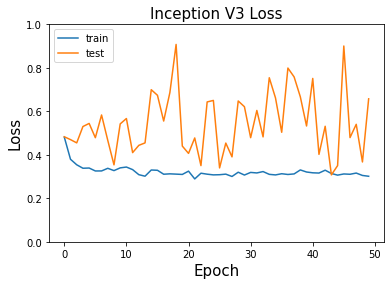

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Inception V3 Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = []
val_accuracy = []

In [ ]:
val_acc[0].to('cpu').numpy()

array(0.625)

In [ ]:
for i in range(len(train_acc)):
  train_accuracy.append(train_acc[i].to('cpu').numpy())
for i in range(len(val_acc)):
  val_accuracy.append(val_acc[i].to('cpu').numpy())

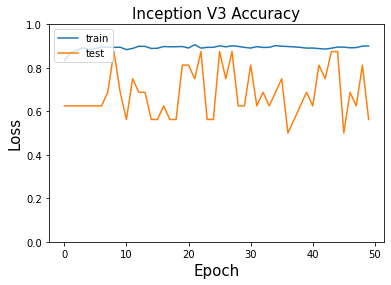

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Inception V3 Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
train_acc[0].to('cpu').numpy()

array(0.8330138)

In [ ]:
train_accuracy

[array(0.8330138),
 array(0.87039877),
 array(0.88132669),
 array(0.89167945),
 array(0.8836273),
 array(0.88765337),
 array(0.89628067),
 array(0.89398006),
 array(0.8943635),
 array(0.89474693),
 array(0.88381902),
 array(0.88918712),
 array(0.89934816),
 array(0.89877301),
 array(0.88918712),
 array(0.89014571),
 array(0.89800613),
 array(0.89685583),
 array(0.89723926),
 array(0.89800613),
 array(0.89129601),
 array(0.90644172),
 array(0.89072086),
 array(0.8943635),
 array(0.8943635),
 array(0.90126534),
 array(0.89666411),
 array(0.90145706),
 array(0.89858129),
 array(0.89417178),
 array(0.89110429),
 array(0.89743098),
 array(0.89398006),
 array(0.89417178),
 array(0.90222393),
 array(0.89953988),
 array(0.89800613),
 array(0.89647239),
 array(0.89417178),
 array(0.89072086),
 array(0.89110429),
 array(0.88861196),
 array(0.88631135),
 array(0.89033742),
 array(0.8955138),
 array(0.89532209),
 array(0.8922546),
 array(0.89321319),
 array(0.89992331),
 array(0.90069018)]

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/Colab Notebooks/sample_inception_pneumonia_model')

In [ ]:
model_ft = torch.load('/content/drive/MyDrive/Colab Notebooks/sample_inception_pneumonia_model')

In [ ]:
running_loss = 0.0
running_corrects = 0
start = time.time()
for inputs, labels in test_loader:
    inputs = inputs.to(device = device, dtype = torch.float32)
    labels = labels.to(device = device)
    # zero the parameter gradients
    optimizer_ft.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(epoch_loss, epoch_acc, time.time()-start))

Test Loss: 0.3342 Acc: 0.8606, Time : 19.1205
